In [3]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import tensorflow.keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD100T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

In [4]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')

drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 100
pad_target = pad_sequences(encode_target, maxlen=max_length_target, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [8]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(max_length_target)
input_drug, att_out_drug = arch_obj.drugSeq(max_length_drug)
#input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model = Model(inputs=[input_target, input_drug], outputs=x_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model1.summary()

In [9]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, y_train, y_test = train_test_split(pad_target, pad_drug, y, test_size=0.2, random_state=20)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [10]:
# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
filepath='checkpoints/'+EXP+'/'+EXP+'_cp.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(
    [train_target, train_drug], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint]
    )

s: 0.7027 - val_accuracy: 0.7251
Epoch 177/500
155/155 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7845
Epoch 00177: val_loss did not improve from 0.68706
155/155 [==============================] - 30s 195ms/step - loss: 0.5493 - accuracy: 0.7845 - val_loss: 0.6889 - val_accuracy: 0.7318
Epoch 178/500
155/155 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7886
Epoch 00178: val_loss did not improve from 0.68706
155/155 [==============================] - 30s 196ms/step - loss: 0.5435 - accuracy: 0.7886 - val_loss: 0.7164 - val_accuracy: 0.7151
Epoch 179/500
155/155 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7861
Epoch 00179: val_loss did not improve from 0.68706
155/155 [==============================] - 30s 196ms/step - loss: 0.5454 - accuracy: 0.7861 - val_loss: 0.7074 - val_accuracy: 0.7198
Epoch 180/500
155/155 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7882
Epoch 00180: val

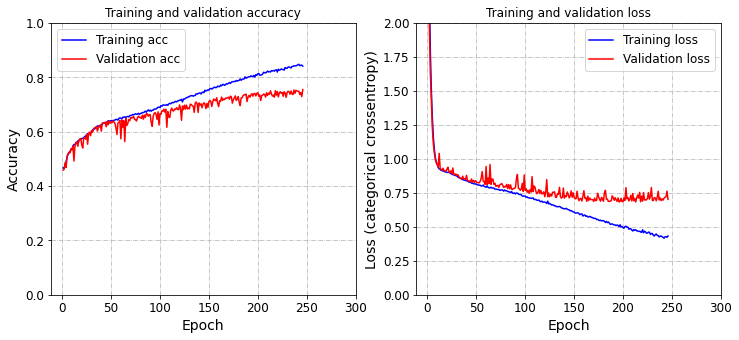

In [31]:
obj.plotTrainingPerf(history,validation=False, save=True)

In [29]:
# Load saved model
saved_model = tf.keras.models.load_model('checkpoints/'+EXP+'/'+EXP+'_cp_7466.hdf5', custom_objects={'attention': architecture.attention()})

# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug)
precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug)

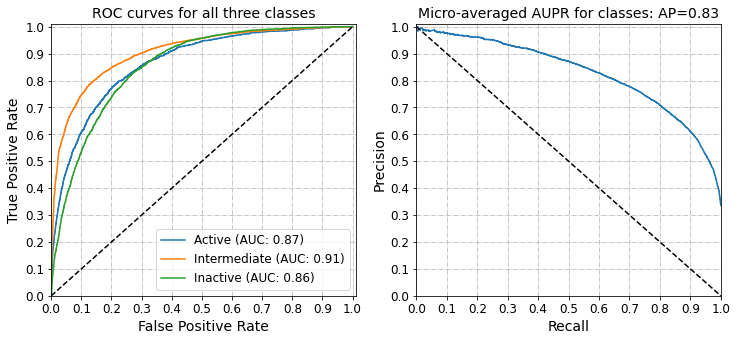

In [30]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, validation=False, save=True)

In [15]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([test_target, test_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
49/49 [==============================] - 6s 128ms/step - loss: 0.6679 - accuracy: 0.7466
test loss, test acc: [0.6679073572158813, 0.746612548828125]


In [22]:
# EXTERNAL VALIDATION
davis_anas_DTI = pd.read_csv('val_data/davis_anas_DTI.csv')
davis_anas_targets = os.listdir('val_data/fasta_davis_anas')  # List all target fasta files
davis_anas_drug_smiles = pd.read_csv('val_data/davis_anas_smiles.csv')

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_anas/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_anas_target_seq = fetchFasta(davis_anas_targets)

100%|██████████| 237/237 [00:00<00:00, 725.69it/s]


In [23]:
eval_P = pd.DataFrame()
for target in davis_anas_DTI['protein_id']:
    dic = davis_anas_target_seq[davis_anas_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_anas_DTI['compound_id']:
    dic = davis_anas_drug_smiles[davis_anas_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

# label/integer encoding output variable: (y)
davis_anas_le = LabelEncoder()
davis_anas_y = davis_anas_le.fit_transform(davis_anas_DTI['activity'].tolist())
# One hot encoding of outputs
davis_anas_y = to_categorical(davis_anas_y)

In [24]:
davis_anas_codes_drug = [char for char in ''.join(set(''.join(davis_anas_drug_smiles['seq'].values)))]
davis_anas_char_dict_drug = obj.create_dict(davis_anas_codes_drug)

davis_anas_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_anas_encode_drug = obj.integer_encoding(eval_T, davis_anas_char_dict_drug) 

# padding sequences
max_length = 1000
davis_anas_pad_target = pad_sequences(davis_anas_encode_target, maxlen=max_length, padding='post', truncating='post')
davis_anas_pad_drug = pad_sequences(davis_anas_encode_drug, maxlen=max_length, padding='post', truncating='post')

davis_anas_pad_target.shape, davis_anas_pad_drug.shape, davis_anas_y.shape

((4255, 1000), (4255, 1000), (4255, 3))

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_anas_pad_target, davis_anas_pad_drug], davis_anas_y, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
17/17 [==============================] - 5s 269ms/step - loss: 12.9705 - accuracy: 0.1027
test loss, test acc: [12.970528602600098, 0.10270269960165024]


In [20]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug)
precision, recall, average_precision = obj.aupr(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug)

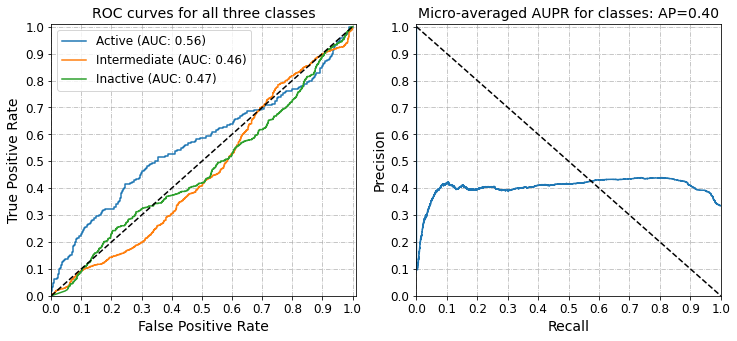

In [21]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, validation=True, save=False)

In [ ]:
collections.Counter(a)